# ORB

A very fast algorithm that creates feature vector from detected keypoints.

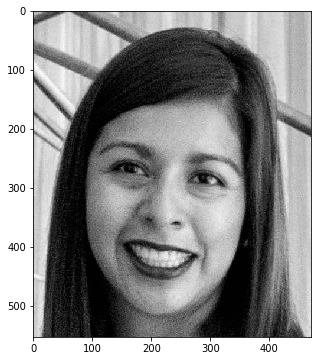

In [1]:
%matplotlib inline 

import cv2
import matplotlib.pyplot as plt

# Set the default figure size 
plt.rcParams['figure.figsize'] = [6,6]

# Load the training image
image = cv2.imread('./images/face.jpeg')
training_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
training_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(training_gray, cmap='gray')

## Locating Keypoints

The first step in the ORB algorithm is to locate all the keypoints in the training image. After the keypoints have been located, ORB creates their corresponding binary feature vectors and groups them together in the ORB descriptor.

`cv2.ORB_create(nfeatures = 500,
               scaleFactor = 1.2,
		       nlevels = 8,
		       edgeThreshold = 31,
		       firstLevel = 0,
		       WTA_K = 2,
		       scoreType = HARRIS_SCORE,
		       patchSize = 31,
		       fastThreshold = 20)`
    
Parameters:

* **nfeatures** - *int*  
Determines the maximum number of features (keypoints) to locate.


* **scaleFactor** - *float*  
Pyramid decimation ratio, must be greater than 1. ORB uses an image pyramid to find features, therefore you must provide the scale factor between each layer in the pyramid and the number of levels the pyramid has. A `scaleFactor = 2` means the classical pyramid, where each next level has 4x less pixels than the previous. A big scale factor will diminish the number of features found.


* **nlevels** - *int*  
The number of pyramid levels. The smallest level will have a linear size equal to input_image_linear_size/pow(scaleFactor, nlevels).


* **edgeThreshold** - - *int*  
The size of the border where features are not detected. Since the keypoints have a specific pixel size, the edges of images must be excluded from the search. The size of the `edgeThreshold` should be equal to or greater than the patchSize parameter.


* **firstLevel** - *int*  
This parameter allows you to determine which level should be treated as the first level in the pyramid. It should be 0 in the current implementation. Usually, the pyramid level with a scale of unity is considered the first level.


* **WTA_K** - *int*  
The number of random pixels used to produce each element of the oriented BRIEF descriptor. The possible values are 2, 3, and 4, with 2 being the default value. For example, a value of 3 means three random pixels are chosen at a time to compare their brightness. The index of the brightest pixel is returned. Since there are 3 pixels, the returned index will be either 0, 1, or 2.


* **scoreType** - *int*  
This parameter can be set to either HARRIS_SCORE or FAST_SCORE. The default HARRIS_SCORE means that the Harris corner algorithm is used to rank features. The score is used to only retain the best features. The FAST_SCORE produces slightly less stable keypoints, but it is a little faster to compute.


* **patchSize** - *int*  
Size of the patch used by the oriented BRIEF descriptor. Of course, on smaller pyramid layers the perceived image area covered by a feature will be larger.

Number of keypoints detected:  175


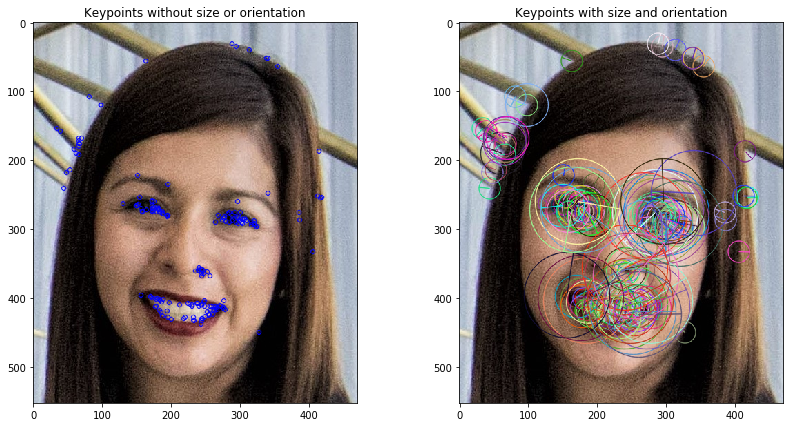

In [2]:
import numpy as np

# 200 max number of keypoints to locate and 2. pyramid decimation ratio.
orb = cv2.ORB_create(200, 2.)

# Find the keypoints in the gray scale training image and compute their ORB
# descriptor. The None parameter indicate that we're not using a mask.
keypoints, descriptor = orb.detectAndCompute(training_gray, None)

keyp_without_size = np.copy(training_image)
keyp_with_size = np.copy(training_image)

# Draw keypoints without size and orientation on one copy of the training img
cv2.drawKeypoints(training_image, keypoints, keyp_without_size, color=(0,0,255))

# Draw keypoints without size and orientation on one copy of the training img
cv2.drawKeypoints(training_image, keypoints, keyp_with_size, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print('Number of keypoints detected: ', len(keypoints))
# Display images
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.subplot(121)
plt.title('Keypoints without size or orientation')
plt.imshow(keyp_without_size)
plt.subplot(122)
plt.title('Keypoints with size and orientation')
plt.imshow(keyp_with_size)
plt.show()


As we can see in the right image, every keypoint has a center, a size, and an angle. The center determines the location of each keypoint in the image; the size of each keypoint is determined by the patch size used by BRIEF to create its feature vector; and the angle tells us the orientation of the keypoint as determined by rBRIEF.

## Feature matching 

Once we have the ORB descriptors for both the training and query images, the final step is to perform keypoint matching between the two images using their corresponding ORB descriptors. This matching is usually performed by a matching function. One of the most commonly used matching functions is called Brute-Force.

`cv2.BFMatcher(normType = cv2.NORM_L2,
		 	  crossCheck = false)`

Parameters:

* **normType**  
Specifies the metric used to determine the quality of the match. By default, `normType = cv2.NORM_L2`, which measures the distance between two descriptors.  However, for binary descriptors like the ones created by ORB, the Hamming metric is more suitable. The Hamming metric determines the distance by counting the number of dissimilar bits between the binary descriptors. When the ORB descriptor is created using `WTA_K = 2`, two random pixels are chosen and compared in brightness. The index of the brightest pixel is returned as either 0 or 1.  Such output only occupies 1 bit, and therefore the ` cv2.NORM_HAMMING` metric should be used.  If, on the other hand, the ORB descriptor is created using `WTA_K = 3`, three random pixels are chosen and compared in brightness. The index of the brightest pixel is returned as either 0, 1, or 2.  Such output will occupy 2 bits, and therefore a special variant of the Hamming distance, known as the `cv2.NORM_HAMMING2` (the 2 stands for 2 bits), should be used instead. Then, for any metric chosen, when comparing the keypoints in the training and query images, the pair with the smaller metric (distance between them) is considered the best match.


* **crossCheck** - *bool* 
A Boolean variable and can be set to either `True` or `False`. Cross-checking is very useful for eliminating false matches. Cross-checking works by performing the matching procedure two times. The first time the keypoints in the training image are compared to those in the query image; the second time, however, the keypoints in the query image are compared to those in the training image (*i.e.* the comparison is done backwards). When cross-checking is enabled a match is considered valid only if keypoint *A* in the training image is the best match of keypoint *B* in the query image and vice-versa (that is, if keypoint *B* in the query image is the best match of point *A* in the training image).

Number of Keypoints Detected In The Training Image:  819
Number of Keypoints Detected In The Query Image:  821

Number of Matching Keypoints Between The Training and Query Images:  718


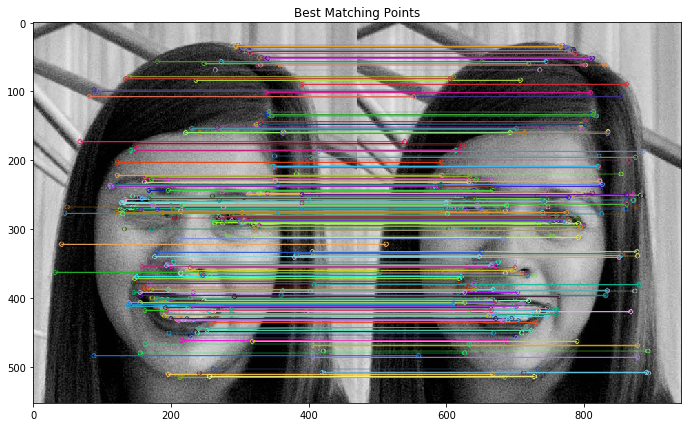

In [3]:
image2 = cv2.imread('./images/face.jpeg')

query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(1000, 2.)
keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perfom the matching between the ORB descriptors of the training and query image 
matches = bf.match(descriptors_train, descriptors_query)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance 
matches = sorted(matches, key=lambda x:x.distance)

print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_query))
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

# Connect the keypoints in the training image with their best matching keypoints in the query image.
# The best matches correspond to the first elements in the sorted matches list, since they are the ones
# with the shorter distance. We draw the first 300 mathces and use flags = 2 to plot the matching keypoints
# without size or orientation.
result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:300], query_gray, flags=2)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# ORB's main propierties

- Scale invariance 
- Rotational invariance
- Illumination invariance
- Noise invariance


In [4]:
def perfom_and_draw_orb(t_img, q_img, n_features=1000, p_ratio=2.):
    gray_training = cv2.cvtColor(t_img, cv2.COLOR_BGR2GRAY)
    gray_query = cv2.cvtColor(q_img, cv2.COLOR_BGR2GRAY)
    
    orb = cv2.ORB_create(n_features, p_ratio)
    
    keypoints_t, descriptors_t = orb.detectAndCompute(gray_training, None)
    keypoints_q, descriptors_q = orb.detectAndCompute(gray_query, None)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors_t, descriptors_q)
    matches = sorted(matches, key=lambda x:x.distance)
    
    print("\nNumber of Keypoints Detected In The Training Image: ", len(keypoints_train))
    print("Number of Keypoints Detected In The Query Image: ", len(keypoints_query))
    print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))
    
    return cv2.drawMatches(gray_training, keypoints_t, gray_query, keypoints_q, matches[:100], gray_query, flags=2)

## Scale invariance 

This means that it is able to detect objects in images regardless of their size.


The Training Image has shape: (553, 471, 3)
The Query Image has shape: (138, 117, 3)

Number of Keypoints Detected In The Training Image:  819
Number of Keypoints Detected In The Query Image:  821

Number of Matching Keypoints Between The Training and Query Images:  60


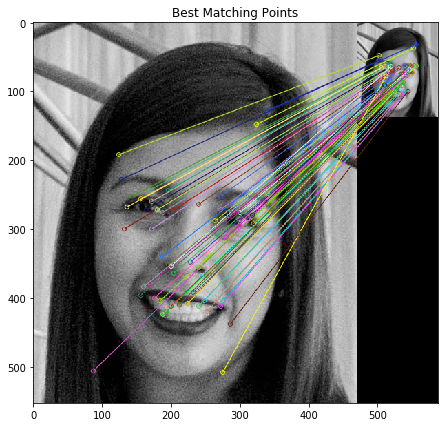

In [5]:
training_image = cv2.imread('./images/face.jpeg')
query_image = cv2.imread('./images/faceQS.png')

print('\nThe Training Image has shape:', training_image.shape)
print('The Query Image has shape:', query_image.shape)

result = perfom_and_draw_orb(training_image, query_image)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

## Rotational Invariance

This means that it is able to detect objects in images regardless of their orientation.


Number of Keypoints Detected In The Training Image:  819
Number of Keypoints Detected In The Query Image:  821

Number of Matching Keypoints Between The Training and Query Images:  653


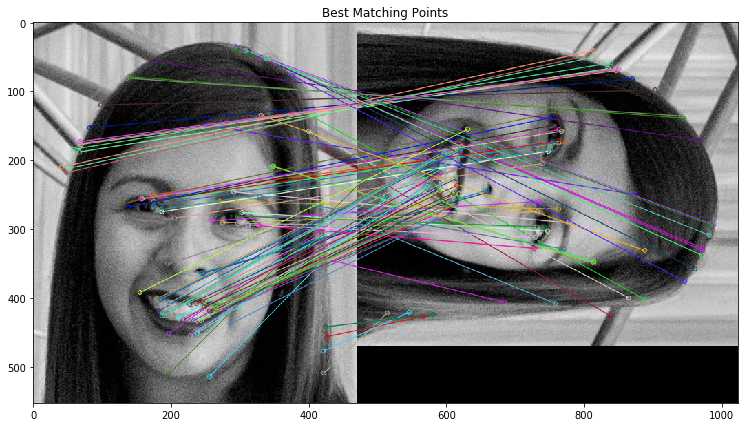

In [6]:
training_image = cv2.imread('./images/face.jpeg')
query_image = cv2.imread('./images/faceR.jpeg')

result = perfom_and_draw_orb(training_image, query_image)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

## Illumination invariance

This means that it is able to detect objects in images regardless of their illumination.


Number of Keypoints Detected In The Training Image:  819
Number of Keypoints Detected In The Query Image:  821

Number of Matching Keypoints Between The Training and Query Images:  503


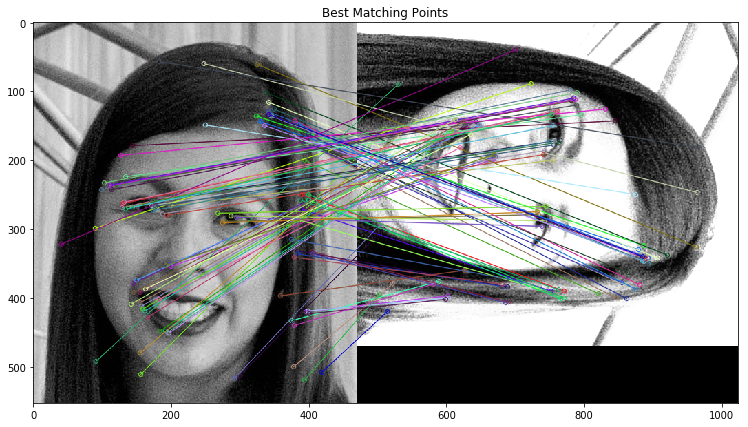

In [7]:
training_image = cv2.imread('./images/face.jpeg')
query_image = cv2.imread('./images/faceRI.png')

result = perfom_and_draw_orb(training_image, query_image)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

## Noise Invariance

This means that it is able to detect objects in images, even if the images have some degree of noise.


Number of Keypoints Detected In The Training Image:  819
Number of Keypoints Detected In The Query Image:  821

Number of Matching Keypoints Between The Training and Query Images:  513


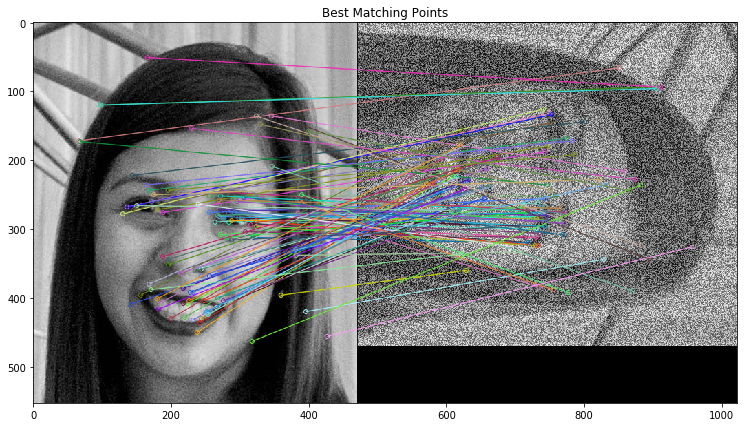

In [8]:
training_image = cv2.imread('./images/face.jpeg')
query_image = cv2.imread('./images/faceRN5.png')

result = perfom_and_draw_orb(training_image, query_image)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# ORB for object detection

We will now implement the ORB algorithm to detect the face in the training image in another image


Number of Keypoints Detected In The Training Image:  819
Number of Keypoints Detected In The Query Image:  821

Number of Matching Keypoints Between The Training and Query Images:  1561


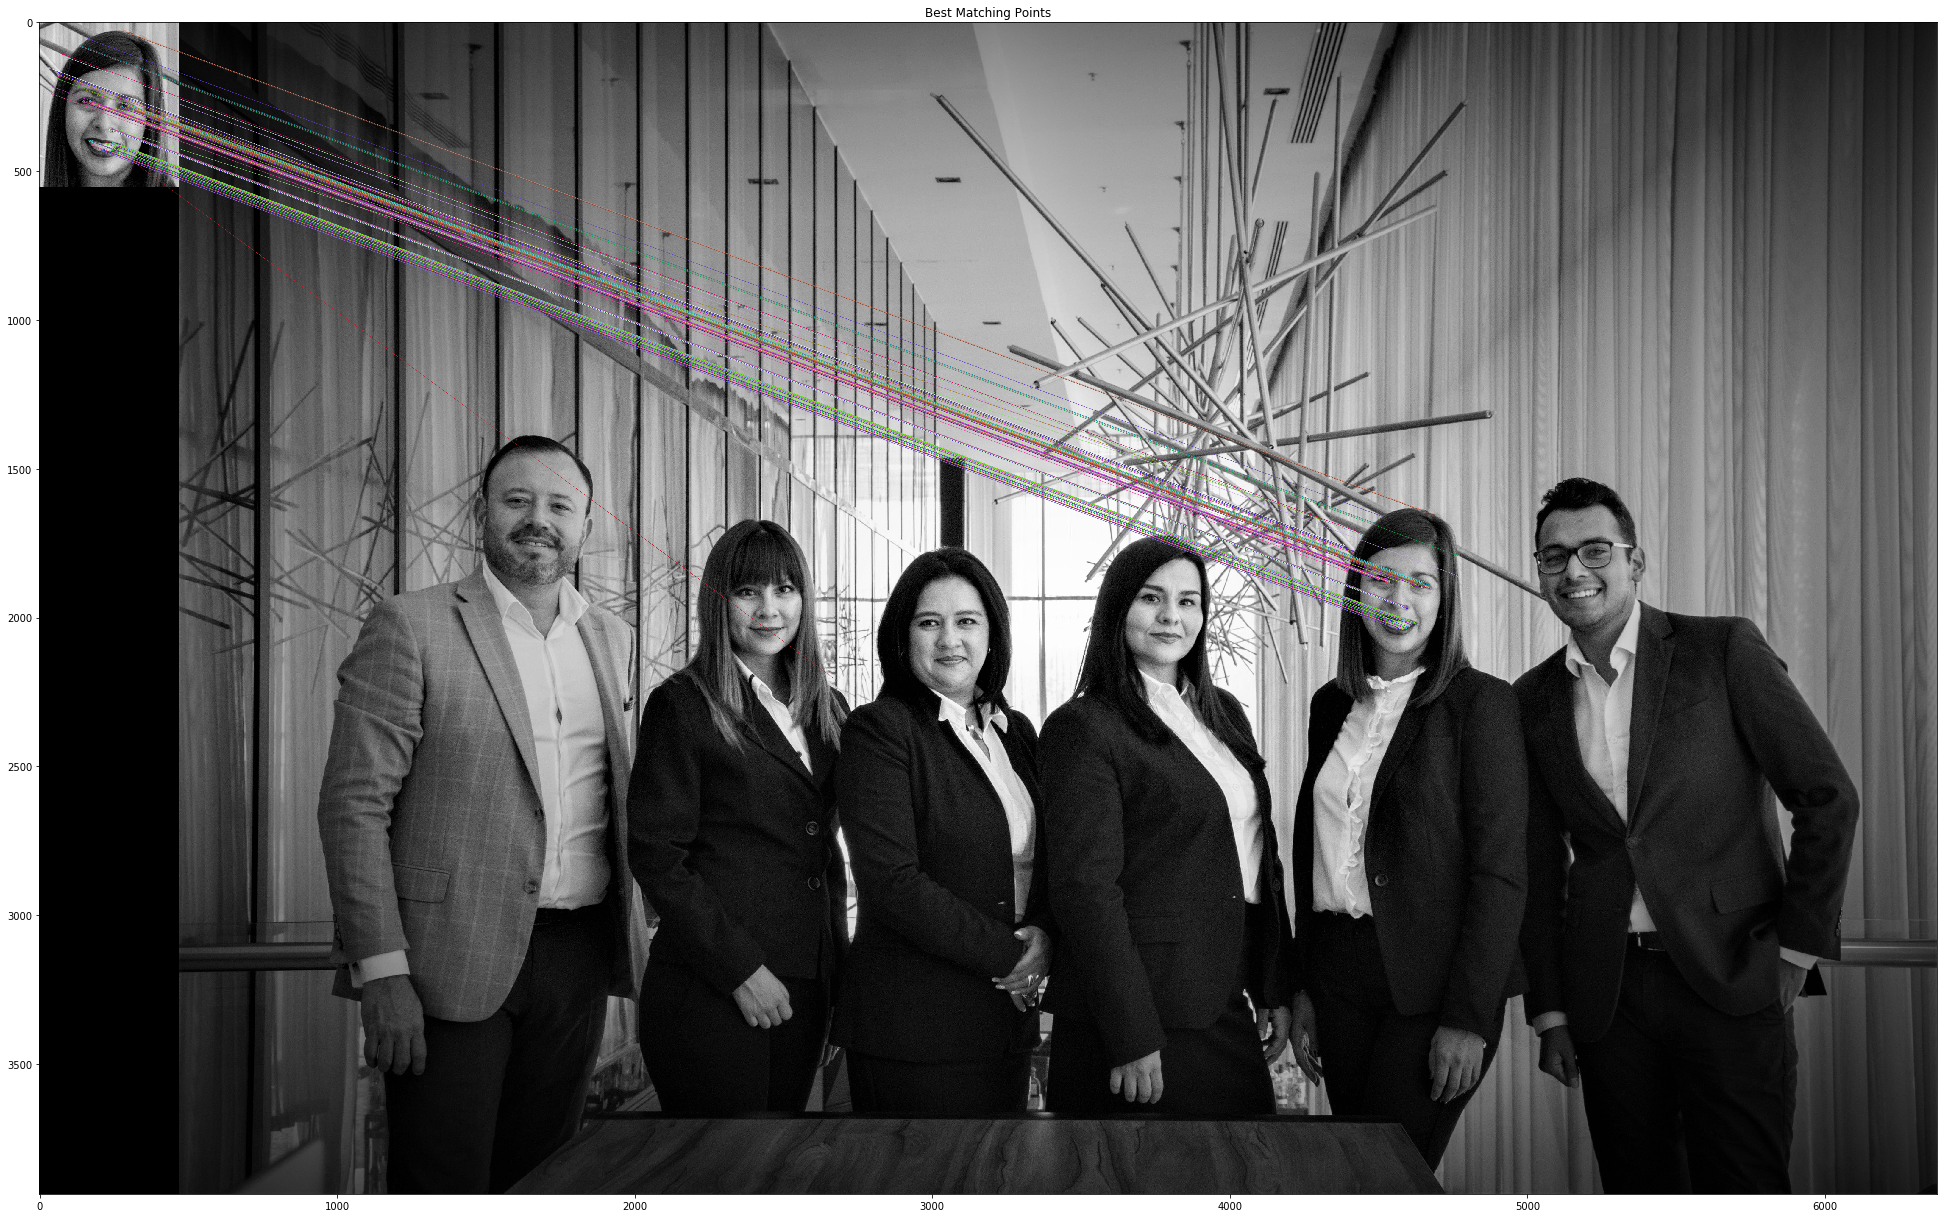

In [9]:
training_image = cv2.imread('./images/face.jpeg')
query_image = cv2.imread('./images/Team.jpeg')

plt.rcParams['figure.figsize'] = [34.0, 34.0]

result = perfom_and_draw_orb(training_image, query_image, n_features=5000)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# ORB for object detection on video

In [11]:
def perfom_and_draw_ORB(t_img, q_img, n_features=1000, p_ratio=2.):
    gray_training = cv2.cvtColor(t_img, cv2.COLOR_BGR2GRAY)
    gray_query = cv2.cvtColor(q_img, cv2.COLOR_BGR2GRAY)
    
    orb = cv2.ORB_create(n_features, p_ratio)
    
    keypoints_t, descriptors_t = orb.detectAndCompute(gray_training, None)
    keypoints_q, descriptors_q = orb.detectAndCompute(gray_query, None)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors_t, descriptors_q)
    matches = sorted(matches, key=lambda x:x.distance)
        
    return cv2.drawMatches(t_img, keypoints_t, q_img, keypoints_q, matches[:115], gray_query, flags=2)

def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def increase_noise(img, noise_level = 40):
    img_with_noise = np.asarray(img)
    noise = np.random.randn(img.shape[0], img.shape[1], img.shape[2])*noise_level
    img_with_noise = img_with_noise + noise
    return np.asarray([np.uint8(np.clip(i,0,255)) for i in img_with_noise])
       
def detectOnVideo(video_path):
    cap = cv2.VideoCapture(video_path)
    print("Number of frames: ", int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
    ret, frame = cap.read()
    cont = 0
    while ret:
        # This depends in the number of frames that you video have
        if cont > 120 and cont < 140:
            new_frame = increase_brightness(frame, 90)
        elif cont > 278 and cont < 288:
            new_frame = increase_noise(frame)
        else:
            new_frame = frame
        result = perfom_and_draw_ORB(image, new_frame, n_features=7000)
        result = cv2.resize(result, (1000, 394))
        cv2.imshow('frame', result)
        ret, frame = cap.read()
        cont += 1
        key = cv2.waitKey(1)
        if key > 0:
            break
            cv2.destroyAllWindows()
            for i in range(1, 5):
                cv2.waitKey(1)
    
    cap.release()
    cv2.destroyAllWindows()

    
image = cv2.imread("images/isabel_22.jpg")
image = cv2.resize(image, (648, 486))
training_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_training = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

video_path = 'images/isabel_22.mp4'
detectOnVideo(video_path)

Number of frames:  298


### detectOnVideo output

![ORB output](images/giphy.gif)